# PTEN loss Survival Analysis for EC

Imports

In [1]:
import pandas as pd
import cptac
import cptac.utils as ut
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
Params
cancer_object: Object. The loaded cancer data set.
all_prot: List. trans proteins used to get proteomics data. 
gene_in: String. Gene used to get mutation status for the Mutation col.
utils: utils package from cptac.  

Returns a dataframe with trans proteomics and mutation status of a specific gene.
'''

def all_prot_format_df(cancer_object, all_prot, gene_in = 'PTEN', utils = ut):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad', 'endometrial'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor')
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = utils.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
            prot_and_mutations = rename_duplicate_cols(prot_and_mutations)
        
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type, how = 'outer')
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    elif cancer_object.get_cancer_type() in ('luad'): 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='proteomics',genes1= gene_in, 
            genes2= all_prot, tissue_type = 'tumor')
        omics = utils.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = rename_duplicate_cols(omics)
        omics = omics.drop(columns='PTEN_CNV')
       
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type, how = 'outer') 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
            mut_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')
        
    elif cancer_object.get_cancer_type() in ('endometrial'):
        # merge cnv with genotype all mut type
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'proteomics', omics_genes = all_prot, tissue_type = 'tumor') # drop Normal samples

        prot_df = prot_and_mutations.iloc[:,:-4] #drop Mutation and Location cols
        mut_type = mut_type[['Mutation']] # Get Mutation col that includes CNV
        merged = prot_df.join(mut_type, how = 'outer') # merge 

        # Create Truncation category and keep truncation and wt
        compare = ['Wildtype_Tumor','Nonsense_Mutation','Frame_Shift_Ins','Frame_Shift_Del']
        get = merged['Mutation'].isin(compare)
        mut_wt = merged[get]
        mut_wt['Mutation'] = np.where(
                        mut_wt['Mutation'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')
    
    mut_wt = mut_wt.rename(columns={col: re.sub(r'_proteomics', '', col) for col in mut_wt.columns.tolist()})
    return mut_wt


In [3]:
''' Adds '_i' to duplicate col names where the int i increases by one with each duplicate 
Returns a df with unique column names. '''

def rename_duplicate_cols(df):
    cols = pd.Series(df.columns[:])

    for dup in cols[cols.duplicated()].unique(): 
        cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]

    # rename the columns with the cols list.
    df.columns=cols
    return df

In [4]:
def get_survival_cols(cancer_object):
    cancer = cancer_object.get_cancer_type()
    #print(cancer)
    
    # get unique survival col names
    if cancer == 'gbm':
        cols = ['vital_status', 'path_diag_to_last_contact_days', 'path_diag_to_death_days']
    if cancer == 'hnscc':
        cols = ['VITAL_STATUS', 'PATHO_DIAG_TO_LAST_CONT_DAYS', 'PATHO_DIAG_TO_DEATH_DAYS']
    if cancer == 'luad':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    if cancer == 'ovarian':
        cols = ['Vital_Status', 'Days_Between_Collection_And_Last_Contact', 'Days_Between_Collection_And_Death']
    if cancer == 'endometrial':
        cols = ['Vital Status', 'Path Diag to Last Contact(Day)', 'Path Diag to Death(days)']
    
    # lscc no follow up or clin matching survival cols

    if cancer == 'brca':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')
    if cancer == 'colon':
        cols = ['Vital Status (at time of last contact)'] 
        print('Use csv')

    return cols

In [5]:
def get_most_recent_last_contact_df(survival_in):
    d = {}
    df = survival_in[['days_to_last_contact']]
    index_list = list(df.index.unique())
    for i in index_list:
        one_index_df = df.loc[[i]]
        # Get the latest number when duplicate records
        most_recent = one_index_df['days_to_last_contact'].max() # get most recent (highest num)
        d[i] = most_recent
        
    last_contact_df = pd.DataFrame.from_dict(d, orient='index', columns=['days_to_last_contact'])
    last_contact_df.index.name = 'Patient_ID'
    
    return last_contact_df   

# Step 1: Import data

In [6]:
cancer = 'EC'
ca = cptac.Endometrial()

# Step 2: Get df with PTEN mutation status and clinical data

In [7]:
cols = get_survival_cols(ca)

clin = ca.get_followup(tissue_type = 'tumor')
#print(clin.follow_up_vital_status.value_counts())
df = clin[cols]
df = df.rename(columns = {cols[0]: 'vital_status', cols[1]: 'days_to_last_contact', cols[2]: 'days_to_death'})

In [12]:
v = df[['vital_status']] 
vitals = v[~v.index.duplicated(keep='last')] # drop dup samples keeping last entry

In [19]:
# check has all death events
print(v.value_counts(), '\n')
print(vitals.value_counts())
vitals.vital_status.unique()

vital_status
Living          194
Deceased          6
dtype: int64 

vital_status
Living          89
Deceased         6
dtype: int64


array(['Living', 'Deceased'], dtype=object)

In [15]:
most_recent_last_contact = get_most_recent_last_contact_df(df) # get most recent days_to_last_contact
d = df[['days_to_death']].dropna()
death = d[~d.index.duplicated(keep='last')]

days_df = death.merge(most_recent_last_contact, on = 'Patient_ID', how = 'outer')
survival_df = days_df.merge(vitals, on = 'Patient_ID', how = 'left')
survival_df

,days_to_death,days_to_last_contact,vital_status
Patient_ID,,,
C3L-00139,422.0,422.0,Deceased
C3L-00771,134.0,134.0,Deceased
C3L-01307,204.0,180.0,Deceased
C3N-00200,732.0,732.0,Deceased
C3N-01520,286.0,286.0,Deceased
...,...,...,...
C3N-01510,NaN,685.0,Living
C3N-01521,NaN,728.0,Living
C3N-01537,NaN,698.0,Living


In [20]:
del_wt = all_prot_format_df(ca, ['PTEN']) # get Mutation col (PTEN del/wt)
print(len(del_wt))
mut_survival = survival_df.join(del_wt, on = 'Patient_ID', how = 'left') # combine keeping only turmors
mut_survival.Mutation.unique()

68


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 313)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 57

array(['Wildtype_Tumor', 'Truncation', nan], dtype=object)

In [17]:
stat = ca.get_clinical()
stat.columns
stat.Sample_Tumor_Normal.value_counts()

Tumor     95
Normal    49
Name: Sample_Tumor_Normal, dtype: int64

# Step 3: Kaplan Meier Plotting

Kaplan Meier plots show the probability of some event occuring over a given length of time, based on some attribute(s). 

In [23]:
survival = mut_survival.dropna(subset = ['Mutation'])
print('total samples with pten and survival data:', len(survival), 
      '\n', survival.vital_status.value_counts(),'\n')

t_df = survival.loc[survival['Mutation'] == 'Truncation']
print('trunc:', len(t_df),'\n', t_df.vital_status.value_counts(), '\n')

wt_df = survival.loc[survival['Mutation'] == 'Wildtype_Tumor']
print('wt:', len(wt_df),'\n', wt_df.vital_status.value_counts())

total samples with pten and survival data: 68 
 Living      62
Deceased     6
Name: vital_status, dtype: int64 

trunc: 53 
 Living      48
Deceased     5
Name: vital_status, dtype: int64 

wt: 15 
 Living      14
Deceased     1
Name: vital_status, dtype: int64


In [24]:
#Make the vital_status column boolean
survival['vital_status'] = survival['vital_status'].replace('Living', False)
print(survival['vital_status'].unique())

survival['vital_status'] = survival['vital_status'].replace('Deceased', True)
print(survival['vital_status'].value_counts())

#survival['vital_status'] = mut_survival['vital_status'].astype('bool')


['Deceased' False]
False    62
True      6
Name: vital_status, dtype: int64


C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [25]:
# Check bool type
print(type(survival['vital_status'].iloc[2]))

<class 'numpy.bool_'>


In [30]:
# Create one column with days between last contact or death
days = ['days_to_last_contact', 'days_to_death']
df_genes = survival.assign(days_to_last_contact_or_death = survival[days].sum(1)).drop(days, 1)
df_genes.vital_status.value_counts()
df_genes

,vital_status,PTEN,Mutation,days_to_last_contact_or_death
Patient_ID,,,,
C3L-00139,True,0.130,Wildtype_Tumor,844.0
C3L-00771,True,0.542,Truncation,268.0
C3L-01307,True,-0.834,Truncation,384.0
C3N-00200,True,0.159,Truncation,1464.0
C3N-01520,True,-1.910,Truncation,572.0
...,...,...,...,...
C3N-01510,False,-2.050,Truncation,685.0
C3N-01521,False,-0.616,Wildtype_Tumor,728.0
C3N-01537,False,-0.164,Wildtype_Tumor,698.0


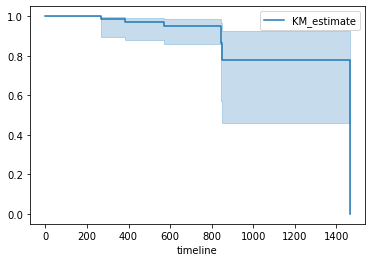

In [27]:
# Plot
time = df_genes['days_to_last_contact_or_death']
status = df_genes['vital_status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Prepare Data for Multivariate Kaplan Meier Plots and Cox's Proportional Hazard Test

In [31]:
# map numeric values to correspond with mutation status
mutation_map = {"Wildtype_Tumor" : 0, "Truncation" : 1}

df_genes['PTEN'] = df_genes['Mutation'].map(mutation_map)

#Then we will drop missing values, as missing values 
#will throw an error in the functions we will use in lifelines.
df_clean = df_genes.dropna(axis=0, how='any').copy()
df_clean = df_clean.drop(columns= 'Mutation') # drop col with str values (info mapped to PTEN as int)

In [33]:
print(df_clean.vital_status.value_counts(), '\n')
print(df_clean.PTEN.value_counts())

False    62
True      6
Name: vital_status, dtype: int64 

1    53
0    15
Name: PTEN, dtype: int64


In [34]:
d = df_clean.loc[df_clean['PTEN'] == 1]
vs = d.loc[d['vital_status'] == True]
vs

,vital_status,PTEN,days_to_last_contact_or_death
Patient_ID,,,
C3L-00771,True,1,268.0
C3L-01307,True,1,384.0
C3N-00200,True,1,1464.0
C3N-01520,True,1,572.0
C3N-01349,True,1,849.0


Verify that your columns are the correct data types.  The event of interest, in this case Vital_Status needs to contain boolean values, and all other columns in the table must be of a numeric type (either int64 or float64).

In [35]:
for col in df_clean.columns:
    print(col, ":", df_clean[col].dtype)

vital_status : bool
PTEN : int64
days_to_last_contact_or_death : float64


# Step 5: Plot Multivariate Survival Risk

0 is wt. 1 is mutant.

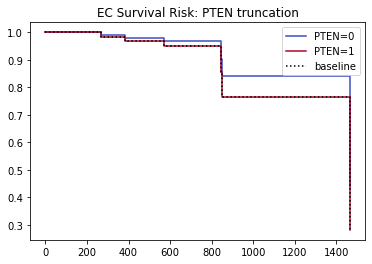

In [37]:
plot_title = cancer+" Survival Risk: PTEN truncation"

cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "days_to_last_contact_or_death", 
        event_col = "vital_status")
cph.plot_partial_effects_on_outcome('PTEN', [0,1], cmap='coolwarm', title=plot_title)    


In [41]:
survival = mut_survival.dropna(subset = ['Mutation'])
print('total samples with pten and survival data:', len(survival), 
      '\n', survival.vital_status.value_counts(),'\n')

t_df = survival.loc[survival['Mutation'] == 'Truncation']
print('trunc:', len(t_df),'\n', t_df.vital_status.value_counts(), '\n')

wt_df = survival.loc[survival['Mutation'] == 'Wildtype_Tumor']
print('wt:', len(wt_df),'\n', wt_df.vital_status.value_counts())

total samples with pten and survival data: 68 
 Living      62
Deceased     6
Name: vital_status, dtype: int64 

trunc: 53 
 Living      48
Deceased     5
Name: vital_status, dtype: int64 

wt: 15 
 Living      14
Deceased     1
Name: vital_status, dtype: int64


In [38]:
cph.print_summary(model="untransformed variables", decimals=3)


<lifelines.CoxPHFitter: fitted with 68 total observations, 62 right-censored observations>
             duration col = 'days_to_last_contact_or_death'
                event col = 'vital_status'
      baseline estimation = breslow
   number of observations = 68
number of events observed = 6
   partial log-likelihood = -17.015
         time fit was run = 2020-11-10 04:31:34 UTC
                    model = untransformed variables

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
PTEN       0.433      1.543      1.124           -1.769            2.636                0.171               13.954

              z     p   -log2(p)
covariate                       
PTEN      0.386 0.700      0.515
---
Concordance = 0.601
Partial AIC = 36.030
log-likelihood ratio test = 0.161 on 1 df
-log2(p) of ll-ratio test = 0.540

# Step 6: Cox's Proportional Hazard Test

With the proportional_hazard_test function, we can now perform Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival. This is shown by the hazard ratio in the column labeled -log2(p) below. In general, a hazard ratio of 1 suggests that an attribute has no effect on overall survival. A ratio less than 1 suggests that an attribute contributes to lower survival risk. A ratio greater than 1 suggests that an attribute contributes to higher survival risk.

In [39]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 68 total observations, 62 right-censored observations>
         test_name = proportional_hazard_test

---
      test_statistic    p  -log2(p)
PTEN            0.27 0.60      0.73

Below, we show the confidence interval for the hazard ratio. 

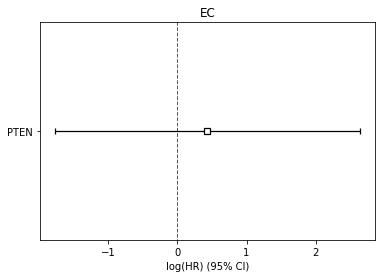

In [40]:
plt.title(cancer)
cph.plot()

In [24]:
# log(hazards ratio) = coef = -0.192

Conclusions: Because the p-value was greater than 0.05, there is insufficient evidence to suggest the PTEN loss effects survival risk.